# Part I: Gradient-Enhanced Polynomial Regression

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
training_data = np.loadtxt('trainingIa.dat')
validation_data = np.loadtxt('validationIa.dat')

X_train, y_train = training_data[:, 0], training_data[:, 1]
X_val, y_val = validation_data[:, 0], validation_data[:, 1]

## I.a) Polynomial Regression

Smallest n for MSE < 10^-3: 9


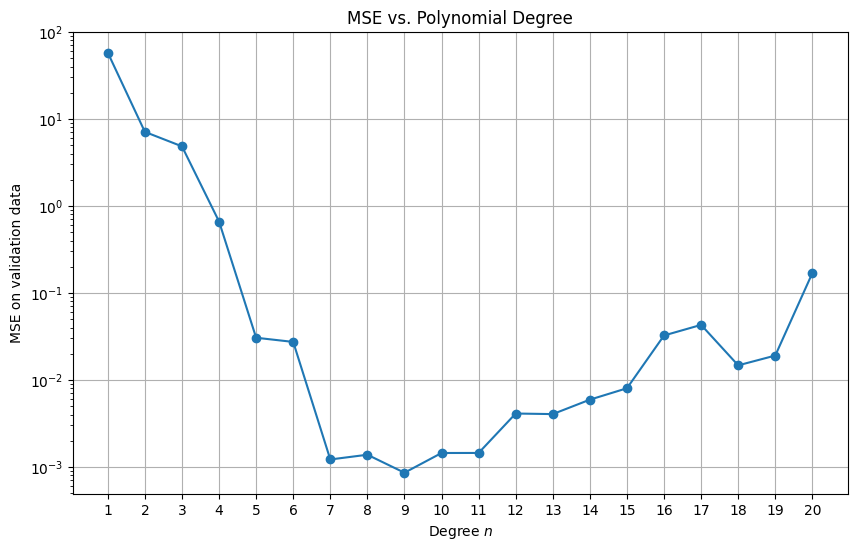

In [4]:
def solve_poly_regression(X, y, n):
    A = np.vander(X, n + 1, increasing=True)
    return np.linalg.lstsq(A, y, rcond=None)[0]

def mse(X, y, theta):
    n = len(theta) - 1
    A = np.vander(X, n + 1, increasing=True)
    return np.mean((y - A @ theta)**2)

mses = []
for n in range(1, 21):
    theta = solve_poly_regression(X_train, y_train, n)
    mses.append(mse(X_val, y_val, theta))

mses = np.array(mses)
best_n = np.where(mses < 1e-3)[0][0] + 1
print(f"Smallest n for MSE < 10^-3: {best_n}")

plt.figure(figsize=(10, 6))
plt.semilogy(range(1, 21), mses, marker='o')
plt.xticks(range(1, 21))  # integer x-axis ticks 1,2,3,...
plt.xlabel(r'Degree $n$')
plt.ylabel(r'MSE on validation data')
plt.title(r'MSE vs. Polynomial Degree')
plt.grid(True)
plt.savefig('plots/mse_vs_degree.png', bbox_inches='tight', dpi=600)
plt.show()


## I.b) Gradient-Enhanced Polynomial Regression

Smallest n for MSE < 10^-3 (with gradient info): 9


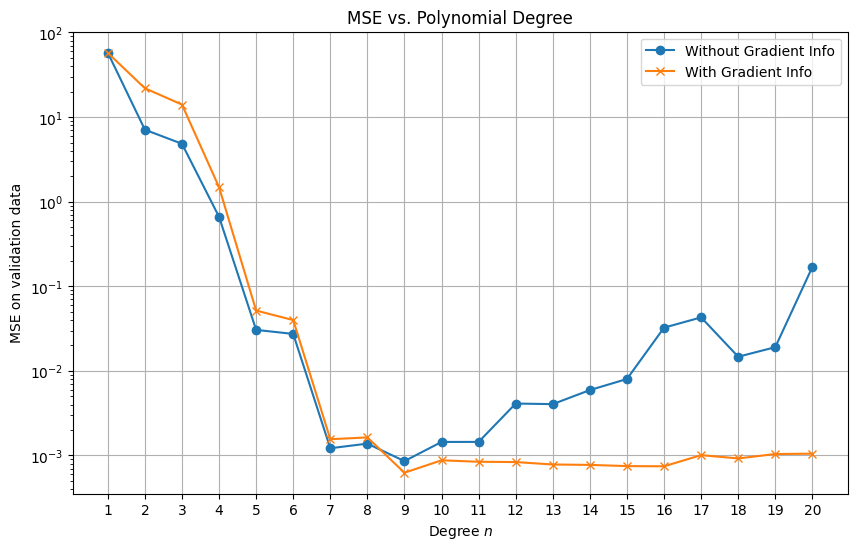

In [5]:
# Load the new data
training_data_b = np.loadtxt('trainingIb.dat')

X_train_b, y_train_b, dy_train_b = training_data_b[:, 0], training_data_b[:, 1], training_data_b[:, 2]

def solve_grad_poly_regression(X, y, dy, n):
    A_fit = np.vander(X, n + 1, increasing=True)
    A_grad = np.vander(X, n, increasing=True) * np.arange(1, n + 1)
    A_grad = np.c_[np.zeros(A_grad.shape[0]), A_grad]
    A = np.vstack([A_fit, A_grad])
    b = np.concatenate([y, dy])
    return np.linalg.lstsq(A, b, rcond=None)[0]

mses_b = []
for n in range(1, 21):
    theta_b = solve_grad_poly_regression(X_train_b, y_train_b, dy_train_b, n)
    mses_b.append(mse(X_val, y_val, theta_b))

mses_b = np.array(mses_b)
best_n_b = np.where(mses_b < 1e-3)[0][0] + 1
print(f"Smallest n for MSE < 10^-3 (with gradient info): {best_n_b}")

plt.figure(figsize=(10, 6))
plt.semilogy(range(1, 21), mses, marker='o', label=r'Without Gradient Info')
plt.semilogy(range(1, 21), mses_b, marker='x', label=r'With Gradient Info')
plt.xticks(range(1, 21))  # make x-axis ticks 1,2,3,...
plt.xlabel(r'Degree $n$')
plt.ylabel(r'MSE on validation data')
plt.title(r'MSE vs. Polynomial Degree')
plt.legend()
plt.grid(True)
plt.savefig('plots/mse_comparison.png', bbox_inches='tight', dpi=600)
plt.show()


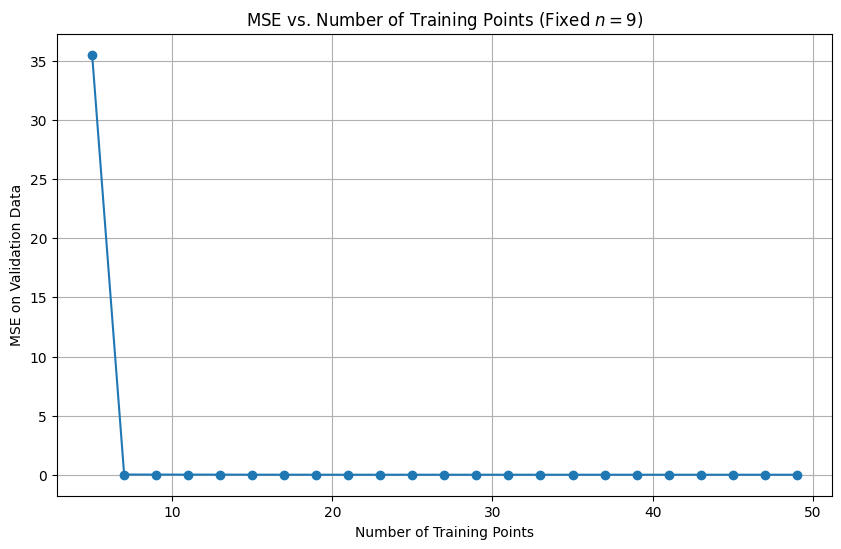

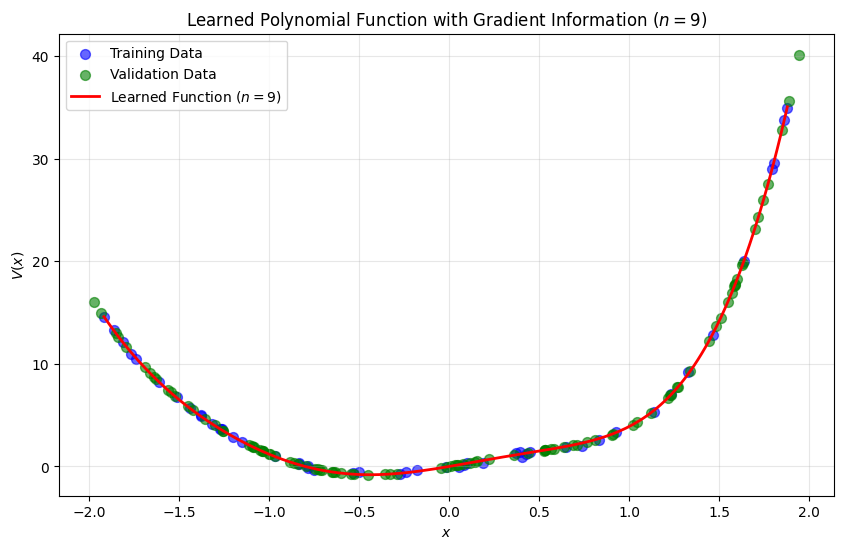

In [6]:
# Part I.b) Additional Analysis: MSE vs Number of Training Points
# Fix n at the best value found (best_n_b) and vary the number of training points

n_fixed = best_n_b
training_sizes = range(5, len(X_train_b) + 1, 2)  # Vary from 5 to max, step of 2
mses_vs_size = []

for size in training_sizes:
    # Use first 'size' training points
    X_subset = X_train_b[:size]
    y_subset = y_train_b[:size]
    dy_subset = dy_train_b[:size]
    
    # Train model with fixed n
    theta_subset = solve_grad_poly_regression(X_subset, y_subset, dy_subset, n_fixed)
    
    # Evaluate on validation set
    mses_vs_size.append(mse(X_val, y_val, theta_subset))

plt.figure(figsize=(10, 6))
plt.plot(training_sizes, mses_vs_size, marker='o')
plt.xlabel(r'Number of Training Points')
plt.ylabel(r'MSE on Validation Data')
plt.title(rf'MSE vs. Number of Training Points (Fixed $n={n_fixed}$)')
plt.grid(True)
plt.savefig('plots/mse_vs_training_size.png', bbox_inches='tight', dpi=600)
plt.show()

# Show the learned function at the best n
theta_best_b = solve_grad_poly_regression(X_train_b, y_train_b, dy_train_b, best_n_b)

# Generate points for smooth plotting
x_plot = np.linspace(X_train_b.min(), X_train_b.max(), 200)
A_plot = np.vander(x_plot, best_n_b + 1, increasing=True)
y_plot = A_plot @ theta_best_b

plt.figure(figsize=(10, 6))
plt.scatter(X_train_b, y_train_b, color='blue', label=r'Training Data', alpha=0.6, s=50)
plt.scatter(X_val, y_val, color='green', label=r'Validation Data', alpha=0.6, s=50)
plt.plot(x_plot, y_plot, 'r-', linewidth=2, label=rf'Learned Function ($n={best_n_b}$)')
plt.xlabel(r'$x$')
plt.ylabel(r'$V(x)$')
plt.title(rf'Learned Polynomial Function with Gradient Information ($n={best_n_b}$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/learned_function_with_gradient.png', bbox_inches='tight', dpi=600)
plt.show()

# Part II: A First Approach to Dynamic Optimisation

## II.a) Regularized Least Squares

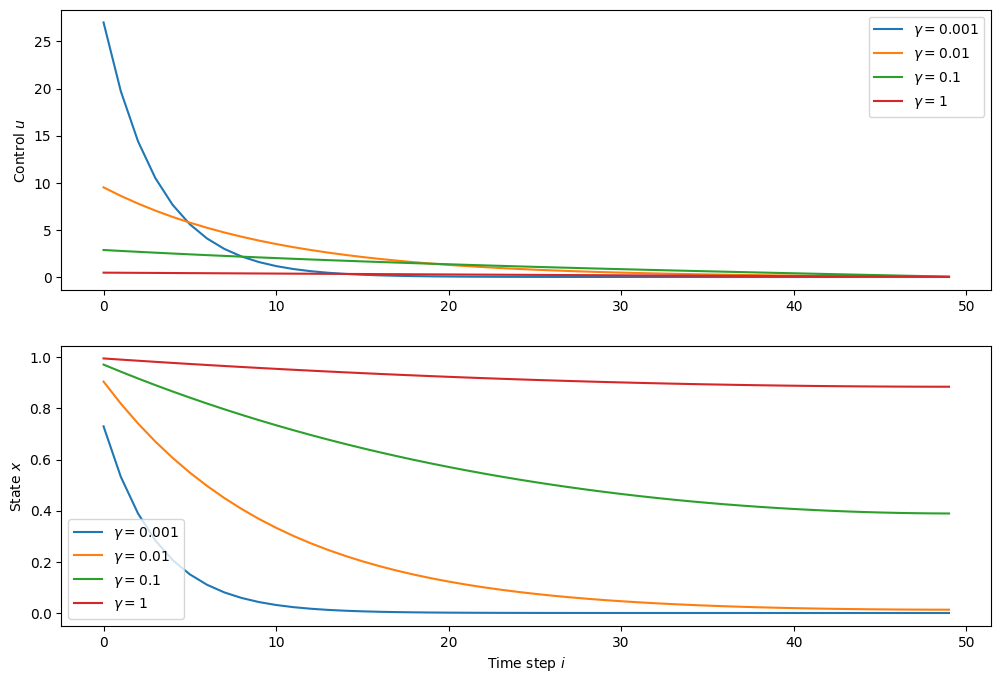

In [7]:
N = 50
x0 = 1
a = 1
b = -0.01
x_bar = 1
gammas = [1e-3, 1e-2, 0.1, 1]

S = np.zeros((N, N))
for i in range(N):
    for j in range(i + 1):
        S[i, j] = b * (a ** (i - j))

c = np.zeros(N)
for i in range(N):
    c[i] = (a ** (i + 1)) * x0

plt.figure(figsize=(12, 8))

for gamma in gammas:
    u = np.linalg.solve(S.T @ S + gamma * np.eye(N), -S.T @ c)
    x = S @ u + c
    
    plt.subplot(2, 1, 1)
    plt.plot(u, label=rf'$\gamma = {gamma}$')
    plt.ylabel(r'Control $u$')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(x, label=rf'$\gamma = {gamma}$')
    plt.ylabel(r'State $x$')
    plt.xlabel(r'Time step $i$')
    plt.legend()

plt.savefig('plots/dynamic_optimisation_a.png', bbox_inches='tight', dpi=600)
plt.show()


## II.b) Coupled System

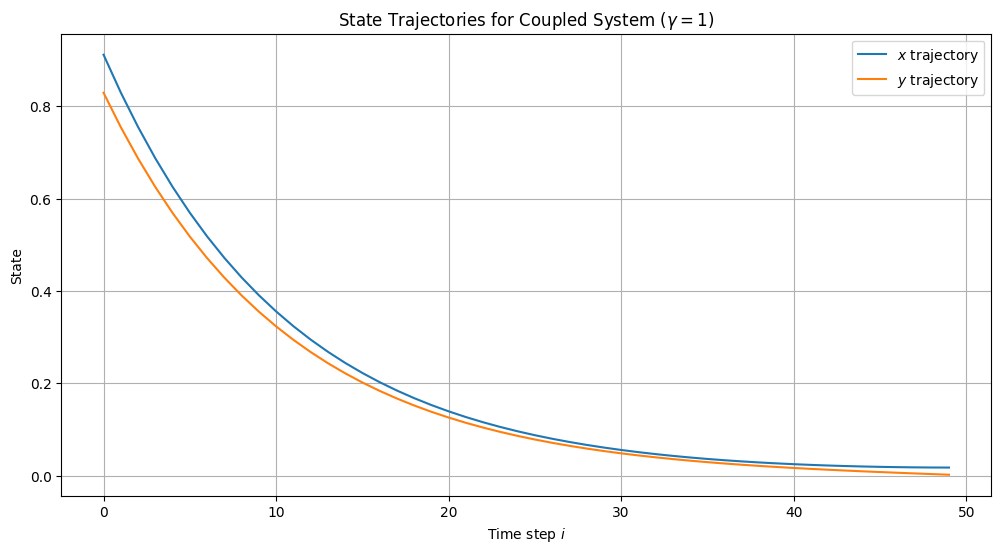

In [8]:
N = 50
a = 1
b = 0.05
x0 = 1
c_param = 0.2
d = -0.5
y0 = 1
gamma = 1

Sx = np.zeros((N, N))
for i in range(N):
    for j in range(i + 1):
        Sx[i, j] = b * (a ** (i - j))

cx = np.zeros(N)
for i in range(N):
    cx[i] = (a ** (i + 1)) * x0

Sy = np.zeros((N, N))
for i in range(N):
    for j in range(i + 1):
        Sy[i, j] = d * (c_param ** (i - j))

cy = np.zeros(N)
for i in range(N):
    cy[i] = (c_param ** (i + 1)) * y0

A = Sx.T @ Sx + gamma * np.eye(N)
B = -gamma * np.eye(N)
C = -gamma * np.eye(N)
D_mat = Sy.T @ Sy + gamma * np.eye(N)

LHS = np.block([[A, B], [C, D_mat]])
RHS = np.concatenate([-Sx.T @ cx, -Sy.T @ cy])

sol = np.linalg.solve(LHS, RHS)
u = sol[:N]
v = sol[N:]

x = Sx @ u + cx
y = Sy @ v + cy

plt.figure(figsize=(12, 6))
plt.plot(x, label=r'$x$ trajectory')
plt.plot(y, label=r'$y$ trajectory')
plt.xlabel(r'Time step $i$')
plt.ylabel(r'State')
plt.legend()
plt.title(r'State Trajectories for Coupled System ($\gamma=1$)')
plt.grid(True)
plt.savefig('plots/dynamic_optimisation_b.png', bbox_inches='tight', dpi=600)
plt.show()


## II.c) Pareto Front

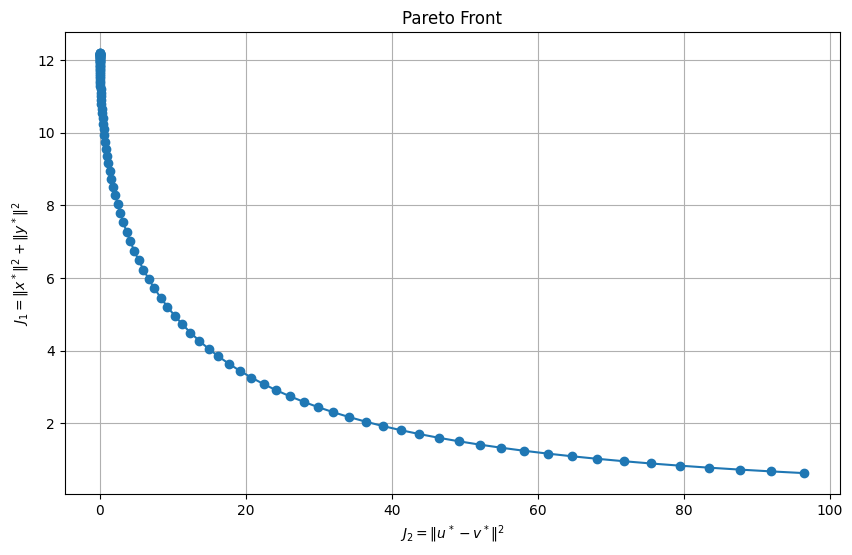

In [9]:
gammas = np.logspace(-2, 2, 100)
J1s = []
J2s = []

for gamma in gammas:
    A = Sx.T @ Sx + gamma * np.eye(N)
    B = -gamma * np.eye(N)
    C = -gamma * np.eye(N)
    D_mat = Sy.T @ Sy + gamma * np.eye(N)

    LHS = np.block([[A, B], [C, D_mat]])
    RHS = np.concatenate([-Sx.T @ cx, -Sy.T @ cy])

    sol = np.linalg.solve(LHS, RHS)
    u = sol[:N]
    v = sol[N:]

    x = Sx @ u + cx
    y = Sy @ v + cy

    J1 = np.linalg.norm(x)**2 + np.linalg.norm(y)**2
    J2 = np.linalg.norm(u - v)**2

    J1s.append(J1)
    J2s.append(J2)

plt.figure(figsize=(10, 6))
plt.plot(J2s, J1s, marker='o')
plt.xlabel(r'$J_2 = \|u^* - v^*\|^2$')
plt.ylabel(r'$J_1 = \|x^*\|^2 + \|y^*\|^2$')
plt.title(r'Pareto Front')
plt.grid(True)
plt.savefig('plots/pareto_front.png', bbox_inches='tight', dpi=600)
plt.show()


## II.d) L1-norm regularisation

In [10]:
def grad_L_epsilon(z, epsilon):
    grad = np.zeros_like(z)
    idx = np.abs(z) <= epsilon
    grad[idx] = z[idx] / epsilon
    grad[~idx] = np.sign(z[~idx])
    return grad

def gradient_descent(u_init, v_init, gamma1, gamma2, epsilon, lr, n_iter):
    u = u_init.copy()
    v = v_init.copy()
    
    for _ in range(n_iter):
        grad_u = 2 * Sx.T @ (Sx @ u + cx) + 2 * gamma2 * (u - v) + gamma1 * grad_L_epsilon(u - v, epsilon)
        grad_v = 2 * Sy.T @ (Sy @ v + cy) - 2 * gamma2 * (u - v) - gamma1 * grad_L_epsilon(u - v, epsilon)
        
        u -= lr * grad_u
        v -= lr * grad_v
        
    return u, v

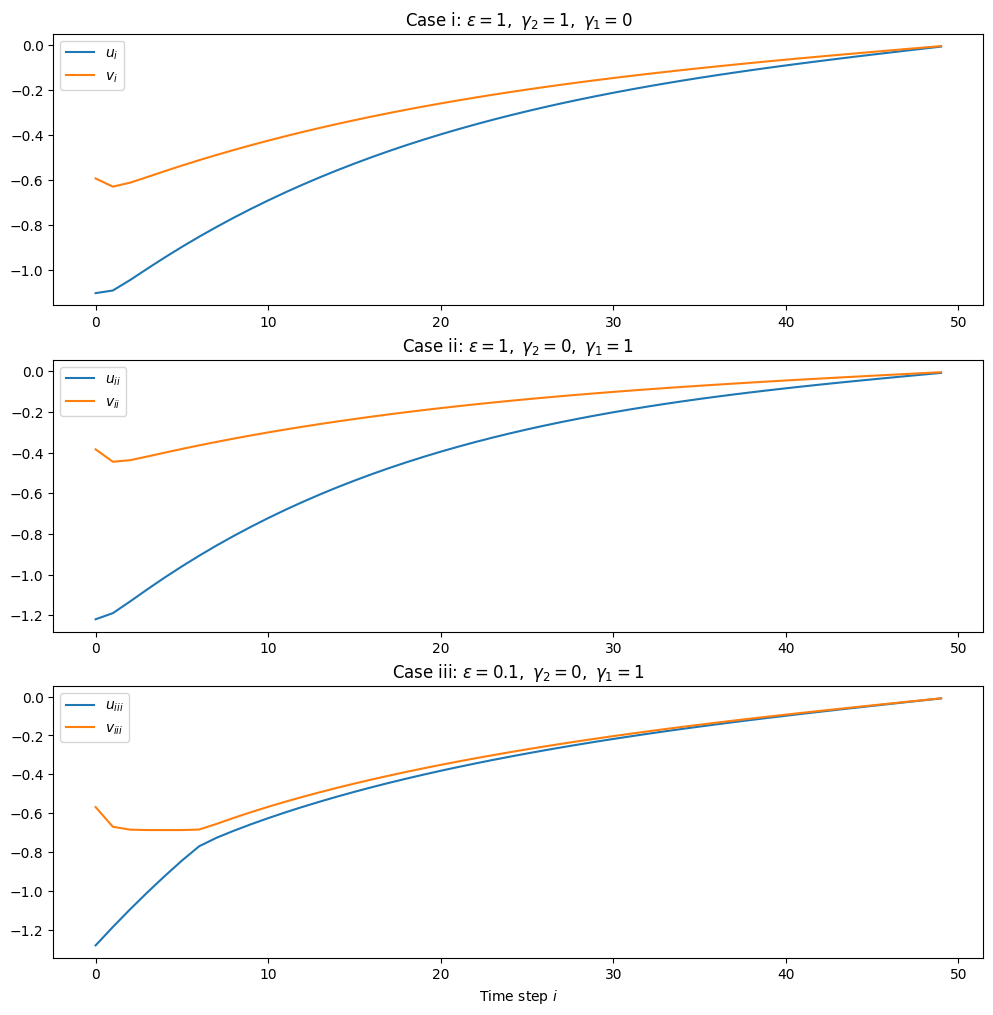

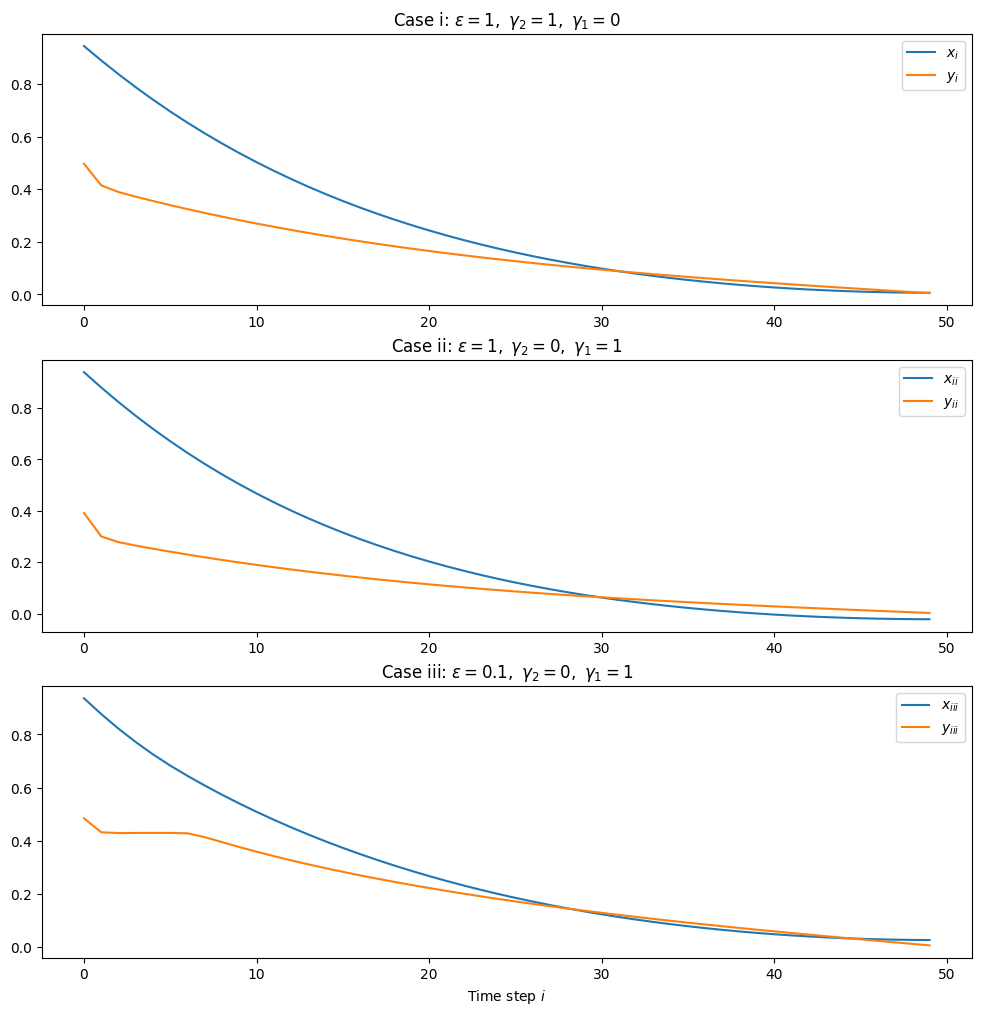

In [11]:
# Parameters
u_init = np.zeros(N)
v_init = np.zeros(N)
lr = 1e-4
n_iter = 10000

# Case i
u_i, v_i = gradient_descent(u_init, v_init, gamma1=0, gamma2=1, epsilon=1, lr=lr, n_iter=n_iter)
x_i = Sx @ u_i + cx
y_i = Sy @ v_i + cy

# Case ii
u_ii, v_ii = gradient_descent(u_init, v_init, gamma1=1, gamma2=0, epsilon=1, lr=lr, n_iter=n_iter)
x_ii = Sx @ u_ii + cx
y_ii = Sy @ v_ii + cy

# Case iii
u_iii, v_iii = gradient_descent(u_init, v_init, gamma1=1, gamma2=0, epsilon=0.1, lr=lr, n_iter=n_iter)
x_iii = Sx @ u_iii + cx
y_iii = Sy @ v_iii + cy

# Plotting
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(u_i, label=r'$u_{i}$')
plt.plot(v_i, label=r'$v_{i}$')
plt.title(r'Case i: $\epsilon=1,\ \gamma_{2}=1,\ \gamma_{1}=0$')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(u_ii, label=r'$u_{ii}$')
plt.plot(v_ii, label=r'$v_{ii}$')
plt.title(r'Case ii: $\epsilon=1,\ \gamma_{2}=0,\ \gamma_{1}=1$')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(u_iii, label=r'$u_{iii}$')
plt.plot(v_iii, label=r'$v_{iii}$')
plt.title(r'Case iii: $\epsilon=0.1,\ \gamma_{2}=0,\ \gamma_{1}=1$')
plt.xlabel(r'Time step $i$')
plt.legend()
plt.savefig('plots/L1_controls.png', bbox_inches='tight', dpi=600)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(x_i, label=r'$x_i$')
plt.plot(y_i, label=r'$y_i$')
plt.title(r'Case i: $\epsilon=1,\ \gamma_{2}=1,\ \gamma_{1}=0$')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(x_ii, label=r'$x_{ii}$')
plt.plot(y_ii, label=r'$y_{ii}$')
plt.title(r'Case ii: $\epsilon=1,\ \gamma_{2}=0,\ \gamma_{1}=1$')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(x_iii, label=r'$x_{iii}$')
plt.plot(y_iii, label=r'$y_{iii}$')
plt.title(r'Case iii: $\epsilon=0.1,\ \gamma_{2}=0,\ \gamma_{1}=1$')
plt.xlabel(r'Time step $i$')
plt.legend()
plt.savefig('plots/L1_states.png', bbox_inches='tight', dpi=600)

plt.show()
